In [1]:
#| default_exp app_v3

#### Competition

[LINK](https://www.kaggle.com/competitions/playground-series-s3e11/overview)

#### Imports

In [2]:
#| export
from fastai.tabular.all import *

from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


import xgboost as xgb

import seaborn as sns

import optuna

import json

#### Downloading Datasets

In [3]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [4]:
#| export
comp = 'playground-series-s3e11'
path = setup_comp(comp, install='fastai')

In [5]:
# copy .gitignore template from my home directory and append project data folder to it
if not os.path.exists('.gitignore'):
    !cp ~/.gitignore .
if comp not in open('.gitignore').read():
    with open('.gitignore', 'a') as f: f.write(f'{comp}')

#### Create Dataframes

In [6]:
#| export
df_train = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)
df_comb = pd.concat([df_train, df_test], ignore_index=True)

In [7]:
#| export
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)
df_comb.drop(['id'], axis=1, inplace=True)

In [8]:
df_train

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360331,7.60,4.0,5.0,5.0,3.0,13.50,1.0,0.0,33.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42
360332,14.44,4.0,4.0,0.0,4.0,18.80,1.0,1.0,18.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85
360333,10.74,3.0,0.0,0.0,2.0,11.30,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,11.04,3.0,1.0,0.0,3.0,10.20,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72


In [9]:
#| export
df_train['store_sales_per_children'] = df_train['store_sales(in millions)'] / df_train['total_children']

In [10]:
#| export
for column in df_train.columns:
    if (list(df_train[column].unique()) == [0.0, 1.0]):
        df_train.loc[:, column] = df_train[column].astype('bool')

In [11]:
#| export
train_idxs = np.arange(len(df_train))
test_idxs = np.arange(len(df_train), len(df_comb))

In [12]:
dep_var = 'cost'
procs = [Categorify, FillMissing, Normalize]
cont, cat = cont_cat_split(df_comb, max_card=1, dep_var=dep_var)
splits = RandomSplitter(valid_pct=0.2)(range_of(df_train))

In [13]:
df_train = df_comb.iloc[train_idxs]
df_test = df_comb.iloc[test_idxs]

In [14]:
#| export
to_final = TabularPandas(df_train, procs, cat, cont, y_names=dep_var, splits=splits)
test_final = TabularPandas(df_test, procs, cat, cont, y_names=None, splits=None)
dls_final = to_final.dataloaders(bs=1024)

### Neural Network Model

#### Train Model

In [15]:
#| export
fast_train = False
epochs = 14

In [16]:
#| export
if fast_train == True:
    learn_final = tabular_learner(dls_final, layers=[200, 100], y_range=(0, 150), metrics=rmse)
    learn_final.fit_one_cycle(epochs, 1e-2)
    learn_final.export('models/tab_learner.pkl')


In [17]:
learn_final = load_learner('models/tab_learner.pkl')

#### Get NN Model Predictions

In [18]:
#| export
test_dl = learn_final.dls.test_dl(df_test)
nn_preds, _ = learn_final.get_preds(dl=test_dl)

In [19]:
nn_preds = nn_preds.squeeze().numpy()
np.savetxt('nn_preds.csv', nn_preds, delimiter=',')

In [20]:
#| export


In [21]:
np.savetxt('nn_preds.csv', nn_preds, delimiter=',')

### Random Forest Model

In [22]:
#| export
xs, y = to_final.train.xs, to_final.train.y
valid_xs, valid_y = to_final.valid.xs, to_final.valid.y
test_xs = test_final.train.xs

In [23]:
#| export
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, 
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [24]:
#| export
def r_mse(pred, y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

In [25]:
#| export
def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

In [26]:
#| export
m = rf(xs, y, n_estimators=100)

In [27]:
rf_mse = m_rmse(m, valid_xs, valid_y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(23.170114, 28.240468)

In [28]:
#| export
rf_preds = m.predict(test_xs)
np.savetxt('rf_preds.csv', rf_preds, delimiter=',')

#### RF Feature Importance

In [29]:
#| export
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False) 

In [30]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
0,store_sales(in millions),0.219277
5,gross_weight,0.205516
8,units_per_case,0.152605
9,store_sqft,0.101840
2,total_children,0.076900
4,avg_cars_at home(approx).1,0.063648
3,num_children_at_home,0.049609
1,unit_sales(in millions),0.035139
6,recyclable_package,0.027735
7,low_fat,0.024051


***

### Gradient Boosting

##### Feature Importance

In [31]:
#| export
train_fi = df_train.drop(columns = ['cost'])
target_fi = df_train['cost']

In [32]:
#| export
def plot_fi(data,ax = None, title = None):
    fi = pd.Series(data, index = train_fi.columns).sort_values(ascending = True)
    fi.plot(kind = 'barh', ax = ax)

In [33]:
#| export
x_train, x_test, y_train, y_test = train_test_split(train_fi, target_fi, test_size=0.2)

In [34]:
#| export
fi_params = {'learning_rate': 0.2456172216493356,
 'max_depth': 10,
 'lambda': 0.0023120639864473262,
 'alpha': 0.5848465230832824,
 'colsample_bytree': 0.9966638720347625,
 'min_child_weight': 0,
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [35]:
#| export
model = xgb.XGBRegressor(**fi_params)


In [36]:
#| export
model.fit(x_train, y_train)

XGBRegressor(alpha=0.5848465230832824, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9966638720347625, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.0023120639864473262,
             learning_rate=0.2456172216493356, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

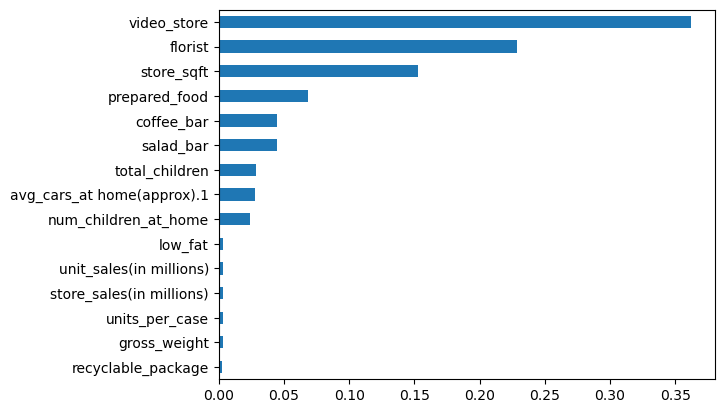

In [37]:
plot_fi(model.feature_importances_)

In [38]:
#| export
r = permutation_importance(model, x_test, y_test, n_repeats=1, random_state=46)

In [39]:
#| export
fi = pd.Series(r['importances'].reshape(15,), index = train_fi.columns).sort_values(ascending = True)

<AxesSubplot: >

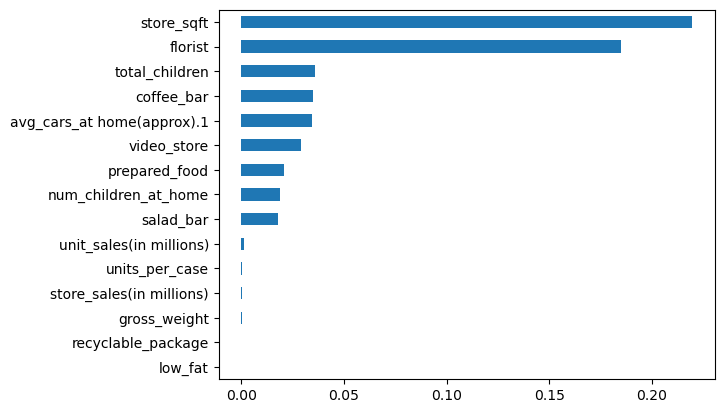

In [40]:
fi.plot(kind = 'barh')

In [41]:
#| export
features = list(fi.index)
cols_to_drop = features[0:6]

In [42]:
#| export
df_train = df_train.drop(columns=cols_to_drop)

In [43]:
#| export
df_test = df_test.drop(columns=cols_to_drop)

In [44]:
#| export
def fe(data):
    data = data.replace([np.inf, -np.inf], 10)
    return data

In [45]:
#| export
train_fe = fe(df_train)
test_fe = fe(df_test)

In [46]:
#| export
train = train_fe.drop(columns=['cost'])

In [47]:
#| export
target = train_fe['cost']

#### Finding the Best Parameters With Optuna

In [48]:
#| export
x_train, x_test, y_train, y_test = train_test_split(train,target, test_size = 0.2)
d_train = xgb.DMatrix(x_train,y_train)
d_test = xgb.DMatrix(x_test,y_test)


In [49]:
#| export
glob_params = {
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmsle'
}

In [50]:
#| export
def objective(trial):
    params = {
        'verbosity':0,
        'learning_rate': trial.suggest_float('learning_rate',1e-10,1.0),
        'max_depth':trial.suggest_int('max_depth', 3, 12),
#        'gamma':trial.suggest_float('gamma',0,8),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree',1e-5,1.0),
        'min_child_weight':trial.suggest_int('min_child_weight',0,1),
        'booster':trial.suggest_categorical("booster", ["dart", "gbtree",'gblinear']),
        'sampling_method': trial.suggest_categorical('sampling_method',['uniform','gradient_based']),
        'grow_policy': trial.suggest_categorical('grow_policy',['depthwise','lossguide']),
#         'reg_alpha': trial.suggest_float("reg_alpha", 0, 1),
#         'reg_lambda': trial.suggest_float("reg_lambda", 0, 1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),    
    }
    num_boost_round = params.pop('num_boost_round')
    params.update(glob_params)
    sch_prm = xgb.train(params, d_train, num_boost_round=200,
                        evals = [(d_test, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=False
                       )
    
    return sch_prm.best_score


In [51]:
#| export
run_study = False

In [52]:
#| export
if run_study == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials = 100,)
    # save study.best_params a json file to load later
    with open('study_params.json', 'w') as fp:
        json.dump(study.best_params, fp)

#### Assigning Best Parameters

In [53]:
#| export
with open('study_params.json', 'r') as fp:
    study_best_params = json.load(fp)

In [54]:
#| export
best_params = {
 'learning_rate': 0.9319687783879956,
 'max_depth': 12,
 'lambda': 0.02022953533538882,
 'alpha': 9.277352577569814e-07,
 'colsample_bytree': 0.7477567097593131,
 'min_child_weight': 0,
 'booster': 'gbtree',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

In [55]:
#| export
best_params.update(study_best_params)

In [56]:
def max_boost_round(trial):
    params = {
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 1500),
    }
    num_boost_round = params.pop('num_boost_round')
    params.update(glob_params)
    sch_prm = xgb.train(params, d_train, num_boost_round=num_boost_round,
                        evals = [(d_test, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=False
                       )
    
    return sch_prm.best_score

In [57]:
run_max_boost = False

In [58]:
#| export
if run_max_boost == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(max_boost_round, n_trials = 20,)
    # save study.best_params a json file to load later
    with open('boost_params.json', 'w') as fp:
        json.dump(study.best_params, fp)

In [59]:
#| export
with open('boost_params.json', 'r') as fp:
    boost_best_params = json.load(fp)

In [60]:
num_boost_round = boost_best_params['num_boost_round']

In [61]:
num_boost_round

1496

In [62]:
best_params

{'learning_rate': 0.9966089304842916,
 'max_depth': 12,
 'lambda': 0.36999767740684797,
 'alpha': 0.00034306004800048104,
 'colsample_bytree': 0.9657745153267124,
 'min_child_weight': 0,
 'booster': 'gbtree',
 'sampling_method': 'uniform',
 'grow_policy': 'depthwise',
 'objective': 'reg:squaredlogerror',
 'eval_metric': 'rmsle'}

***

#### Creating GB Model

In [63]:
#| export
cont, cat = cont_cat_split(df_train, max_card=1, dep_var='cost')

In [64]:
to = TabularPandas(df_train, procs, cat, cont, y_names='cost', splits=splits)

In [65]:
to_test = TabularPandas(df_test, procs, cat, cont, y_names=None, splits=None)

In [66]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y
test_xs = to_test.xs

In [67]:
gb_train = xgb.DMatrix(xs, label=y)
gb_valid = xgb.DMatrix(valid_xs, label=valid_y)
gb_test = xgb.DMatrix(test_xs)

In [68]:
# use best params in xgb.train
model =  xgb.train(best_params, gb_train, num_boost_round = num_boost_round,
                        evals = [(gb_valid, 'valid')], 
                        early_stopping_rounds=20, verbose_eval=True
                       )

[0]	valid-rmsle:3.58281
[1]	valid-rmsle:3.00976
[2]	valid-rmsle:2.45566
[3]	valid-rmsle:1.92696
[4]	valid-rmsle:1.43362
[5]	valid-rmsle:0.99218
[6]	valid-rmsle:0.63171
[7]	valid-rmsle:0.40070
[8]	valid-rmsle:0.31932
[9]	valid-rmsle:0.30673
[10]	valid-rmsle:0.30363
[11]	valid-rmsle:0.30162
[12]	valid-rmsle:0.30091
[13]	valid-rmsle:0.29980
[14]	valid-rmsle:0.29935
[15]	valid-rmsle:0.29861
[16]	valid-rmsle:0.29823
[17]	valid-rmsle:0.29794
[18]	valid-rmsle:0.29766
[19]	valid-rmsle:0.29733
[20]	valid-rmsle:0.29698
[21]	valid-rmsle:0.29658
[22]	valid-rmsle:0.29631
[23]	valid-rmsle:0.29609
[24]	valid-rmsle:0.29595
[25]	valid-rmsle:0.29574
[26]	valid-rmsle:0.29560
[27]	valid-rmsle:0.29544
[28]	valid-rmsle:0.29529
[29]	valid-rmsle:0.29516
[30]	valid-rmsle:0.29503
[31]	valid-rmsle:0.29497
[32]	valid-rmsle:0.29486
[33]	valid-rmsle:0.29477
[34]	valid-rmsle:0.29472
[35]	valid-rmsle:0.29466
[36]	valid-rmsle:0.29460
[37]	valid-rmsle:0.29453
[38]	valid-rmsle:0.29446
[39]	valid-rmsle:0.29444
[40]	valid

#### Getting GB Predictions

In [69]:
xgb_preds = model.predict(xgb.DMatrix(test_xs))

In [70]:
np.savetxt('xgb_preds.csv', xgb_preds, delimiter=',')

In [71]:
xgb_preds = np.loadtxt('xgb_preds.csv', delimiter=',')

In [72]:
xgb_preds

array([ 89.77347565,  93.32284546,  93.64485168, ...,  93.64485168,
       105.09801483, 114.05037689])

***

#### K-Folds Cross Validation

In [76]:
k_folds_train = False

In [77]:
if k_folds_train == True:
    # set the number of folds
    num_folds = 10
    # create empty list to store the loglosses
    loglosses = []
    # create empty array to store the predictions
    k_gb_preds = np.zeros(len(to_test))
    # create a kfold object
    kf = KFold(n_splits=num_folds, shuffle = True, random_state = 1042)
    # loop through each fold
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X=xs, y=y)):
        # print the fold number
        print('-'*20, 'Fold:', fold + 1, '-'*20)
        # split the data into train and validation
        X_train, X_test = train.iloc[trn_idx], train.iloc[val_idx]
        # split the target into train and validation
        y_train, y_test = target.iloc[trn_idx], target.iloc[val_idx]
        
        # create the train and validation data
        d_train = xgb.DMatrix(X_train,y_train)
        d_test = xgb.DMatrix(X_test,y_test)
        
        # train the model
        k_gb_model =  xgb.train(best_params, d_train, num_boost_round = num_boost_round,
                            evals = [(d_test, 'valid')], 
                            early_stopping_rounds=20, verbose_eval=True
                        )
    #     preds = model.predict(d_test)
    #     logloss = metrics.log_loss(y_test, preds)
    #     loglosses.append(logloss)
    #     print(f'Logloss: {logloss}')
        # predict on the test set
        preds = k_gb_model.predict(xgb.DMatrix(test_xs))
        # add the predictions to the final predictions array
        k_gb_preds += preds / num_folds

    # save k_gb_preds to csv
    np.savetxt('k_gb_preds.csv', k_gb_preds, delimiter=',')

-------------------- Fold: 1 --------------------
[0]	valid-rmsle:3.58449
[1]	valid-rmsle:3.01137
[2]	valid-rmsle:2.45719
[3]	valid-rmsle:1.92845
[4]	valid-rmsle:1.43503
[5]	valid-rmsle:0.99348
[6]	valid-rmsle:0.63268
[7]	valid-rmsle:0.40090
[8]	valid-rmsle:0.31874
[9]	valid-rmsle:0.30602
[10]	valid-rmsle:0.30266
[11]	valid-rmsle:0.30083
[12]	valid-rmsle:0.30020
[13]	valid-rmsle:0.29921
[14]	valid-rmsle:0.29875
[15]	valid-rmsle:0.29785
[16]	valid-rmsle:0.29755
[17]	valid-rmsle:0.29724
[18]	valid-rmsle:0.29698
[19]	valid-rmsle:0.29669
[20]	valid-rmsle:0.29636
[21]	valid-rmsle:0.29610
[22]	valid-rmsle:0.29583
[23]	valid-rmsle:0.29561
[24]	valid-rmsle:0.29548
[25]	valid-rmsle:0.29527
[26]	valid-rmsle:0.29519
[27]	valid-rmsle:0.29496
[28]	valid-rmsle:0.29480
[29]	valid-rmsle:0.29463
[30]	valid-rmsle:0.29449
[31]	valid-rmsle:0.29444
[32]	valid-rmsle:0.29432
[33]	valid-rmsle:0.29426
[34]	valid-rmsle:0.29422
[35]	valid-rmsle:0.29413
[36]	valid-rmsle:0.29409
[37]	valid-rmsle:0.29401
[38]	valid

In [78]:
if 'k_gb_preds' not in locals():
    k_gb_preds = np.loadtxt('k_gb_preds.csv', delimiter=',')

***

In [79]:
xgb_mse = r_mse(model.predict(gb_valid), valid_y)
xgb_mse

28.086836

#### Ensemble of All Predictions

In [80]:
rf_preds, nn_preds, k_gb_preds, xgb_preds

(array([103.19975602,  90.61927308,  99.64053258, ...,  98.74795598,
        117.19904502, 117.47012035]),
 array([ 97.841866,  97.04937 , 100.45175 , ..., 100.70537 , 110.78925 ,
        105.85622 ], dtype=float32),
 array([103.21230888,  73.93023109,  99.01429653, ...,  99.01429653,
         77.44030571, 104.49899864]),
 array([ 89.77347565,  93.32284546,  93.64485168, ...,  93.64485168,
        105.09801483, 114.05037689]))

In [81]:
#| export
ens_preds = (nn_preds + rf_preds + k_gb_preds + xgb_preds) / 4

In [82]:
ens_preds

array([ 98.50685152,  88.73042986,  98.18785813, ...,  98.02811806,
       102.6316547 , 110.46892808])

In [83]:
#| export
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_df['cost'] = ens_preds
sample_df.to_csv('submission.csv', index=False)

In [84]:
!head submission.csv

id,cost
360336,98.50685152189608
360337,88.73042986065168
360338,98.187858125947
360339,95.20417322629864
360340,82.10619426692267
360341,98.66584977088426
360342,99.05226536910499
360343,88.47338648507689
360344,85.50924296757655


In [85]:
new_sub_nums = sample_df['cost'].to_numpy()

In [97]:
ls

app_v1/                           models/
app_v2/                           nn_preds.csv
app_v3/                           playground-series-s3e11/
benchmark_submission.csv          playground-series-s3e11.zip
boost_params.json                 rf_preds.csv
k_gb_preds.csv                    study_params.json
media_campaign_cost_base.ipynb    submission.csv
media_campaign_cost_boost.ipynb   xgb_preds.csv
media_campaign_cost_k_fold.ipynb


In [101]:
benchmark_df = pd.read_csv('benchmark_submission.csv')

In [102]:
benchmark_nums = benchmark_df['cost'].to_numpy()

In [103]:
benchmark_nums

array([101.39742739,  88.34353213, 101.63097338, ..., 101.3100521 ,
       102.89292277, 107.8740633 ])

In [87]:
new_sub_nums

array([ 98.50685152,  88.73042986,  98.18785813, ...,  98.02811806,
       102.6316547 , 110.46892808])

In [104]:
# find the average difference between the new and old submission numbers
diffs = np.mean(np.abs(new_sub_nums - benchmark_nums))
diffs


1.6441357250998618

In [105]:
submit = True

In [106]:
if not iskaggle and submit:
    from kaggle import api
    api.competition_submit_cli(file_name='submission.csv', message="drop id column", competition=comp)

100%|██████████| 5.77M/5.77M [00:02<00:00, 2.18MB/s]


In [ ]:
import nbdev
nbdev.export.nb_export('media_campaign_cost_boost.ipynb', 'app_v3')
print("export successful")